# In this notebook I will create 3d interpolations of the mach probe measurements.

In [880]:
import numpy as np
from scipy.interpolate import griddata

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

In [881]:
from pyvisfile.vtk import write_structured_grid
from pytools.obj_array import make_obj_array

In [882]:
import sys
sys.path.append('../../read_from_sql/')
import read_from_sql

In [883]:
sys.path.append('/Users/vonderlinden2/rsx_analysis/mach_probe_analysis')
import ion_current_to_mach_number as ic_to_mach
sys.path.append('/Users/vonderlinden2/rsx_analysis/time_alignment/source')
import absolute_times as at

In [884]:
database = '/Users/vonderlinden2/rsx_analysis/shots_database/source/shots.db'
table = 'Shots'

In [885]:
z_direction_1, z_direction_2 = 0, 180
y_direction_1, y_direction_2 = 90, 270

In [886]:
angle_signs = {0: 1,
               180: -1,
               90: -1,
               0: 1}

# Set minimum spectral density

In [887]:
min_spectral_density = 1.6e-8

# Collect suitable shots from the plane_campaign_1, plane_campaign_2, and line_campaign 

## plane_campaign_1

In [868]:
condition_z_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

condition_y_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(y_direction_1) +
                    " OR mach_orientation = " + str(y_direction_2) + ")")

In [869]:
cursor, connection = read_from_sql.cursor_with_rows(condition_z_0416,
                                                    database,
                                                    table)
z_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

In [870]:
cursor, connection = read_from_sql.cursor_with_rows(condition_y_0416,
                                                    database,
                                                    table)
y_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

## plane_campaign_2

In [871]:
condition_z_302 = ("campaigns = 'mach_probe_plane_campaign_2'"
                   " AND fiducial_pre_crowbar_gyration_spectral_density > "
                   + str(min_spectral_density) +
                   " AND mach_signals_exist = 1"
                   " AND (mach_orientation = " + str(z_direction_1) +
                   " OR mach_orientation = " + str(z_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_302,
                                                    database,
                                                    table)
z_0302_shots = cursor.fetchall()
cursor.close()
connection.close()

## line_campaign_1

In [872]:
condition_z_0249 = ("campaigns = 'mach_probe_line_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_0249,
                                                    database,
                                                    table)

z_0249_shots = cursor.fetchall()
cursor.close()
connection.close()

# Define functions

In [873]:
def times_to_indexes(time, times):
    r"""
    """
    indexes = np.searchsorted(time, times)
    for i, index in enumerate(indexes):
        indexes[i] = (index-1 +
                      np.argmin([np.abs(times[i] - time[index - 1]),
                                 np.abs(times[i] - time[index]),
                                 np.abs(times[i] - time[index + 1])]))
    return indexes

In [874]:
def run_mach_analysis(shots, time_points, angle_signs):
    mach_out, x_out, y_out, z_out = [], [], [], []
    for shot in shots:

        shot_number = shot['shot']
        times = at.absolute_times(shot_number, shot, [],
                                  number_of_delays=time_points)
        (mach, time,
         r_background_std,
         l_background_std) = ic_to_mach.mach_number(shot_number, 
                                                    mach_r_node_name=shot['mach_r_node'],
                                                    mach_l_node_name=shot['mach_l_node'])
        mach = mach*angle_signs[shot['mach_orientation']]
        indexes = times_to_indexes(time, times)
        mach_out.append(mach[indexes])
        x_out.append(shot['mach_x'])
        y_out.append(shot['mach_y'])
        z_out.append(shot['mach_z'])
    x_out = np.asarray(x_out)
    y_out = np.asarray(y_out)
    z_out = np.asarray(z_out)
    mach_out = np.asarray(mach_out)
    mach_out = np.swapaxes(mach_out, 0, 1)
    measurements = {'a_out': mach_out,
                    'x_out': x_out,
                    'y_out': y_out,
                    'z_out': z_out}
    return measurements

In [875]:
mach_z_0416_measurements = run_mach_analysis(z_0416_shots,
                                             21, 
                                             angle_signs) 
mach_y_0416_measurements = run_mach_analysis(y_0416_shots,
                                             21, 
                                             angle_signs)
mach_z_0302_measurements = run_mach_analysis(z_0302_shots,
                                             21, 
                                             angle_signs)
mach_z_0249_measurements = run_mach_analysis(z_0249_shots,
                                             21, 
                                             angle_signs)

In [876]:
mach_y_0416_measurements['a_out'].shape

(21, 264)

# Start interpolating

# First interpolate the y values on plane 4

In [877]:
spatial_increment = 0.005

x_min, x_max = -0.023, 0.024
y_min, y_max = -0.02, 0.03
z_min, z_max = 0.416, 0.416
mach_y_0416_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_min, x_max = -0.023, 0.024
y_min, y_max = -0.02, 0.03
z_min, z_max = 0.302, 0.416

mach_z_plane_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_min, x_max = -0.005, -0.005
y_min, y_max = -0.005, 0.03
z_min, z_max = 0.249, 0.416
mach_z_line_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

In [878]:
import structured_3d_vtk as struc_3d
reload(struc_3d)

<module 'structured_3d_vtk' from 'structured_3d_vtk.pyc'>

In [879]:
scalars_y = []

for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_y_0416_points, 
     mach_y_0416_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_y_0416_measurements}, 
                                                                      time_point, 
                                                                      [0.416])
    to_remove = []
    for i, value in enumerate(mach_y_0416_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_y_0416_values = np.delete(mach_y_0416_values, to_remove)
    mach_y_0416_points = np.delete(mach_y_0416_points, to_remove, 0)
    
    grid_points, sizes = struc_3d.bounded_grid(mach_y_0416_bounds, spatial_increment)
    
    grid_points = np.delete(grid_points, 2, 1)
    mach_y_0416_points = np.delete(mach_y_0416_points, 2, 1)
    
    mach_y_0416_interpolated = struc_3d.interpolate_scalar(grid_points, mach_y_0416_points, 
                                                           mach_y_0416_values)
    assert np.sum(np.isnan(mach_y_0416_interpolated)) == 0
    
    
    mach_y_0416_grid_points = np.insert(grid_points, 2, np.ones((grid_points.shape[0]))*0.416, axis=1)
    
    vtk_grid = struc_3d.prepare_mesh(mach_y_0416_grid_points, sizes)
    mach_y_0416_vtk_scalar = struc_3d.prepare_scalar(mach_y_0416_interpolated, sizes)
    
    scalars_y.append(mach_y_0416_vtk_scalar)
    
    output_path = '../output/2016-06-14/'
    write_structured_grid(output_path + 
                          'mach_y_' + str(time_point).zfill(4) + '.vts', vtk_grid, point_data=[('mach_y', 
                                                                                                mach_y_0416_vtk_scalar)])

time_point 0
time_point 1
time_point 2
time_point 3
time_point 4
time_point 5
time_point 6
time_point 7
time_point 8
time_point 9
time_point 10
time_point 11
time_point 12
time_point 13
time_point 14
time_point 15
time_point 16
time_point 17
time_point 18
time_point 19
time_point 20


In [847]:
scalars_y

[array([[[[-0.45934949],
          [-0.36767331],
          [-0.40009737],
          [-0.38018383],
          [-0.17417895],
          [-0.1023349 ],
          [-0.31794994],
          [-0.26338841],
          [-0.1018355 ],
          [-0.10999427]],
 
         [[-0.49882481],
          [-0.32882122],
          [-0.36000188],
          [-0.30144081],
          [-0.12573992],
          [-0.07694917],
          [-0.10155494],
          [-0.08526166],
          [-0.10529451],
          [-0.09131307]],
 
         [[-0.50153683],
          [-0.30030238],
          [-0.27994421],
          [-0.18885203],
          [-0.17520103],
          [-0.12930375],
          [-0.08382278],
          [-0.07253816],
          [-0.03062887],
          [-0.12371091]],
 
         [[-0.23834234],
          [-0.18063304],
          [-0.16766748],
          [-0.05804393],
          [-0.05066276],
          [ 0.01323451],
          [ 0.04471732],
          [-0.00790344],
          [-0.09046131],
          [-0.06

# Interpolate the z values on plane 4 & 2

# Investigate the distrbution of nans in interpolated grid

In [848]:
scalars = []

for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_z_plane_points, 
     mach_z_plane_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_z_0416_measurements,
                                                                        0.302: mach_z_0302_measurements},
                                                                       time_point, 
                                                                       [0.302, 0.416])
    
    for i, value in enumerate(mach_z_plane_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_z_plane_values = np.delete(mach_z_plane_values, to_remove)
    mach_z_plane_points = np.delete(mach_z_plane_points, to_remove, 0)
    
    
    grid_points, sizes = struc_3d.bounded_grid(mach_z_plane_bounds, spatial_increment)
    mach_z_plane_interpolated = struc_3d.interpolate_scalar(grid_points, mach_z_plane_points, 
                                                            mach_z_plane_values)
    
    vtk_grid = struc_3d.prepare_mesh(grid_points, sizes) 
    scalar = struc_3d.prepare_scalar(mach_z_plane_interpolated, sizes)
    scalars.append(scalar)
scalars = np.asarray(scalars)

time_point 0
time_point 1
time_point 2
time_point 3
time_point 4
time_point 5
time_point 6
time_point 7
time_point 8
time_point 9
time_point 10
time_point 11
time_point 12
time_point 13
time_point 14
time_point 15
time_point 16
time_point 17
time_point 18
time_point 19
time_point 20


In [849]:
np.sum(np.isnan(scalars))

0

In [850]:
is_nan = np.where(np.isnan(scalars))
not_nan = np.where(np.invert(np.isnan(scalars)))

In [851]:
heatmap_scalars = np.array(scalars)
heatmap_scalars[is_nan] = 1
heatmap_scalars[not_nan] = 0

In [852]:
vtk_grid.shape

(3, 10, 10, 23)

In [853]:
is_nan_for_grid = np.where(np.isnan(scalars[0, 0, :, :, :]))

In [854]:
vtk_grid[0][is_nan_for_grid]

array([], dtype=float64)

In [855]:
heatmap_scalars.shape

(21, 1, 10, 10, 23)

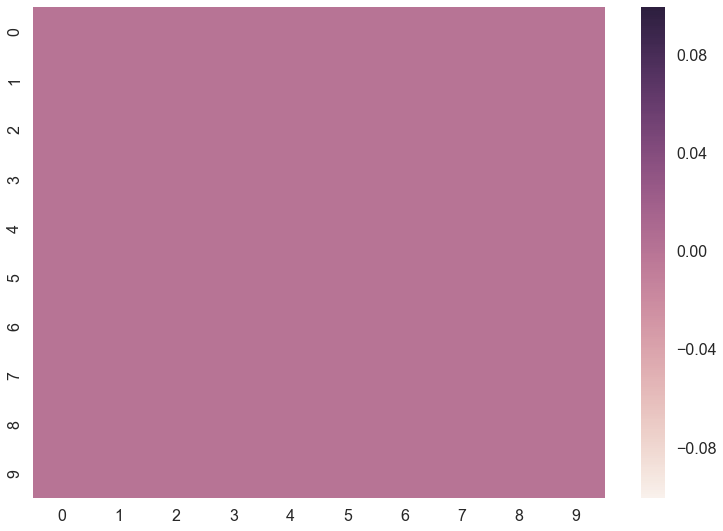

In [856]:
sns.heatmap(heatmap_scalars[0, 0, :, :, 0])

In [857]:
np.sum(np.isnan(scalars))

0

In [858]:
for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_z_plane_points, 
     mach_z_plane_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_z_0416_measurements,
                                                                        0.302: mach_z_0302_measurements},
                                                                       time_point, 
                                                                       [0.302, 0.416])
    
    for i, value in enumerate(mach_z_plane_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_z_plane_values = np.delete(mach_z_plane_values, to_remove)
    mach_z_plane_points = np.delete(mach_z_plane_points, to_remove, 0)
    
    
    grid_points, sizes = struc_3d.bounded_grid(mach_z_plane_bounds, spatial_increment)
    mach_z_plane_interpolated = struc_3d.interpolate_scalar(grid_points, mach_z_plane_points, 
                                                            mach_z_plane_values)
    

    assert np.sum(np.isnan(mach_z_plane_interpolated)) == 0
    
    mach_vector = np.zeros((3, mach_z_plane_interpolated.size))
    plane_0416 = np.where(grid_points[:, 2] == 0.416)[0]
    mach_vector[1][plane_0416] = mach_y_0416_interpolated  
    mach_vector[2] = mach_z_plane_interpolated
    
    vtk_grid = struc_3d.prepare_mesh(grid_points, sizes)
    mach_vtk_vector = struc_3d.prepare_vector(mach_vector, sizes)
    
    output_path = '../output/2016-06-14/'
    write_structured_grid(output_path + 
                          'mach' + str(time_point).zfill(4) + '.vts', vtk_grid, point_data=[('mach', 
                                                                                            mach_vtk_vector)])

time_point 0
time_point 1
time_point 2
time_point 3
time_point 4
time_point 5
time_point 6
time_point 7
time_point 8
time_point 9
time_point 10
time_point 11
time_point 12
time_point 13
time_point 14
time_point 15
time_point 16
time_point 17
time_point 18
time_point 19
time_point 20


# Interpolate the z values on a line on plane 1, 2, & 4

In [859]:
for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_z_line_points, 
     mach_z_line_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_z_0416_measurements,
                                                                       0.302: mach_z_0302_measurements,
                                                                       0.249: mach_z_0249_measurements}, 
                                                                      time_point, 
                                                                      [0.249, 0.302, 0.416])
    
    for i, value in enumerate(mach_z_line_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_z_line_values = np.delete(mach_z_line_values, to_remove)
    mach_z_line_points = np.delete(mach_z_line_points, to_remove, 0)
    
    grid_points, sizes = struc_3d.bounded_grid(mach_z_line_bounds, spatial_increment)
    mach_z_line_interpolated = struc_3d.interpolate_scalar(grid_points, mach_z_line_points, 
                                                           mach_z_line_values)

    
    #assert np.sum(np.isnan(mach_z_line_interpolated)) == 0
    
    vtk_grid = struc_3d.prepare_mesh(grid_points, sizes)
    mach_z_line_vtk = struc_3d.prepare_scalar(mach_z_line_interpolated, sizes)

time_point 0
time_point 1
time_point 2
time_point 3
time_point 4
time_point 5
time_point 6
time_point 7
time_point 8
time_point 9
time_point 10
time_point 11
time_point 12
time_point 13
time_point 14
time_point 15
time_point 16
time_point 17
time_point 18
time_point 19
time_point 20


In [549]:
not_nan = np.invert(np.isnan(mach_z_0249_measurements['a_out'][0]))

In [550]:
mach_z_0249_measurements['y_out'][not_nan]

array([], dtype=float64)

In [495]:
mach_z_line_points

array([[ 0.028,  0.015,  0.302],
       [ 0.028,  0.04 ,  0.302],
       [ 0.028,  0.045,  0.302],
       [ 0.028, -0.015,  0.302],
       [ 0.028, -0.02 ,  0.302],
       [ 0.028, -0.025,  0.302],
       [ 0.028, -0.03 ,  0.302],
       [ 0.028, -0.035,  0.302],
       [ 0.028, -0.04 ,  0.302],
       [ 0.028, -0.045,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.021,  0.03 ,  0.302],
       [ 0.021,  0.035,  0.302],
       [ 0.021,  0.04 ,  0.302],
       [ 0.021, -0.005,  0.302],
       [ 0.021, -0.01 ,  0.302],
       [ 0.021, -0.015,  0.302],
       [ 0.021, -0.03 ,  0.302],
       [ 0.021, -0.045,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.014,  0.005,  0.302],
       [ 0.014,  0.01 ,  0.302],
       [ 0.014,  0.015,  0.302],
       [ 0.014,  0.025,  0.302],
       [ 0

In [485]:
grid_points

array([[-0.005     , -0.005     ,  0.249     ],
       [-0.005     , -0.005     ,  0.25406061],
       [-0.005     , -0.005     ,  0.25912121],
       [-0.005     , -0.005     ,  0.26418182],
       [-0.005     , -0.005     ,  0.26924242],
       [-0.005     , -0.005     ,  0.27430303],
       [-0.005     , -0.005     ,  0.27936364],
       [-0.005     , -0.005     ,  0.28442424],
       [-0.005     , -0.005     ,  0.28948485],
       [-0.005     , -0.005     ,  0.29454545],
       [-0.005     , -0.005     ,  0.29960606],
       [-0.005     , -0.005     ,  0.30466667],
       [-0.005     , -0.005     ,  0.30972727],
       [-0.005     , -0.005     ,  0.31478788],
       [-0.005     , -0.005     ,  0.31984848],
       [-0.005     , -0.005     ,  0.32490909],
       [-0.005     , -0.005     ,  0.3299697 ],
       [-0.005     , -0.005     ,  0.3350303 ],
       [-0.005     , -0.005     ,  0.34009091],
       [-0.005     , -0.005     ,  0.34515152],
       [-0.005     , -0.005     ,  0.350

In [486]:
is_nan = np.where(np.isnan(mach_z_line_vtk))
not_nan = np.where(np.invert(np.isnan(mach_z_line_vtk)))

In [487]:
heatmap = np.array(mach_z_line_vtk)
heatmap[is_nan] = 1
heatmap[not_nan] = 0

In [488]:
heatmap.shape

(1, 1, 7, 34)

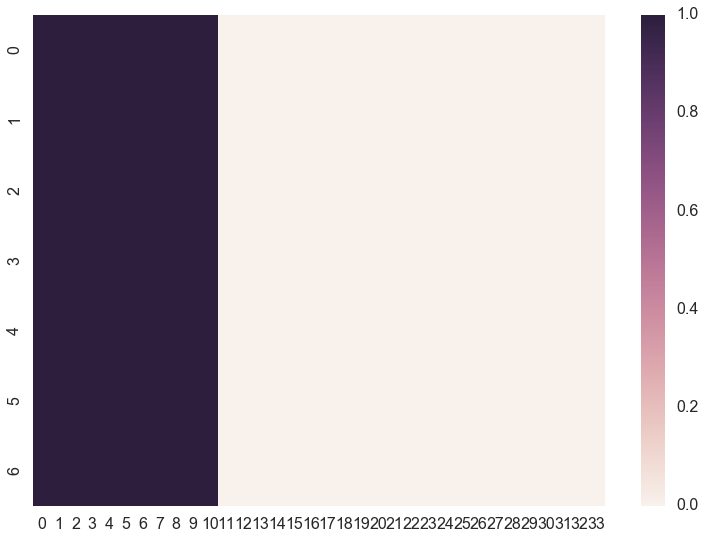

In [489]:
sns.heatmap(heatmap[0,0])

In [490]:
heatmap

array([[[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [493]:
vtk_grid[1][0][is_nan[0]]

array([[-0.005, -0.005, -0.005, ..., -0.005, -0.005, -0.005],
       [-0.005, -0.005, -0.005, ..., -0.005, -0.005, -0.005],
       [-0.005, -0.005, -0.005, ..., -0.005, -0.005, -0.005],
       ..., 
       [-0.005, -0.005, -0.005, ..., -0.005, -0.005, -0.005],
       [-0.005, -0.005, -0.005, ..., -0.005, -0.005, -0.005],
       [-0.005, -0.005, -0.005, ..., -0.005, -0.005, -0.005]])

In [492]:
vtk_grid.shape

(3, 1, 7, 34)